In [1]:
# 02.0 — setup
import sys
from pathlib import Path
PROJECT_ROOT = Path.cwd().parents[0] if "notebooks" in str(Path.cwd()) else Path.cwd()
if str(PROJECT_ROOT) not in sys.path: sys.path.insert(0, str(PROJECT_ROOT))

import joblib
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# 02.1 — load processed data
data_path = PROJECT_ROOT / "data" / "processed" / "processed_features.csv"
if not data_path.exists():
    raise FileNotFoundError("Run data_preprocessing first to generate processed_features.csv")

df = pd.read_csv(data_path)
print(df.shape)
df.head()


(9120, 24)


,machine_id,end_index,end_time,temperature_mean,temperature_std,temperature_min,temperature_max,temperature_trend,vibration_mean,vibration_std,...,pressure_std,pressure_min,pressure_max,pressure_trend,rpm_mean,rpm_std,rpm_min,rpm_max,rpm_trend,label
0,1,50,2025-11-09T13:14:47.878597,60.32280,0.179012,60.025,60.566,-0.009637,0.401704,0.048726,...,0.055687,0.862,1.065,-0.002370,1455.18,24.966930,1423.0,1503.0,1.608691,0
1,1,51,2025-11-09T13:15:47.878597,60.31954,0.178002,60.025,60.566,-0.009371,0.404486,0.049790,...,0.053249,0.862,1.065,-0.002148,1456.62,25.823160,1423.0,1507.0,1.681200,0
2,1,52,2025-11-09T13:16:47.878597,60.31394,0.177363,60.025,60.566,-0.009274,0.406990,0.049989,...,0.050649,0.862,1.065,-0.001897,1458.18,26.514668,1423.0,1508.0,1.736903,0
3,1,53,2025-11-09T13:17:47.878597,60.30766,0.177285,60.025,60.566,-0.009263,0.409186,0.049619,...,0.048237,0.862,1.065,-0.001643,1459.70,27.085236,1423.0,1508.0,1.785210,0
4,1,54,2025-11-09T13:18:47.878597,60.30084,0.178197,60.025,60.566,-0.009377,0.411844,0.048942,...,0.045616,0.862,1.065,-0.001227,1461.16,27.622715,1423.0,1508.0,1.833565,0


In [3]:
# 02.2 — prepare X, y
feature_cols = []
sensors = ['temperature','vibration','pressure','rpm']
for s in sensors:
    feature_cols += [f"{s}_mean", f"{s}_std", f"{s}_min", f"{s}_max", f"{s}_trend"]

X = df[feature_cols].values
y = df['label'].astype(int).values


In [4]:
# 02.3 — scale, split, train model
scaler = StandardScaler()
Xs = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.2, random_state=42, stratify=y if len(np.unique(y))>1 else None)

rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

joblib.dump(rf, PROJECT_ROOT / "models" / "rf_model.pkl")
joblib.dump(scaler, PROJECT_ROOT / "models" / "scaler.pkl")
print("✅ Model and scaler saved.")


✅ Model and scaler saved.


              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1602
           1       0.94      0.82      0.88       222

    accuracy                           0.97      1824
   macro avg       0.96      0.91      0.93      1824
weighted avg       0.97      0.97      0.97      1824

ROC AUC: 0.9967917355557805


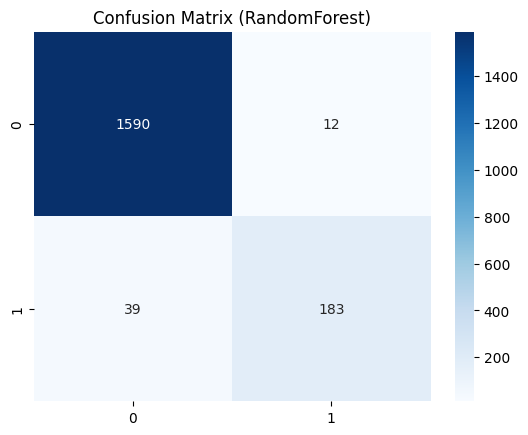

In [5]:
# 02.4 — evaluate
preds = rf.predict(X_test)
probs = rf.predict_proba(X_test)[:,1]
print(classification_report(y_test, preds))
if len(np.unique(y_test))>1:
    print("ROC AUC:", roc_auc_score(y_test, probs))
sns.heatmap(confusion_matrix(y_test, preds), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (RandomForest)")
plt.show()


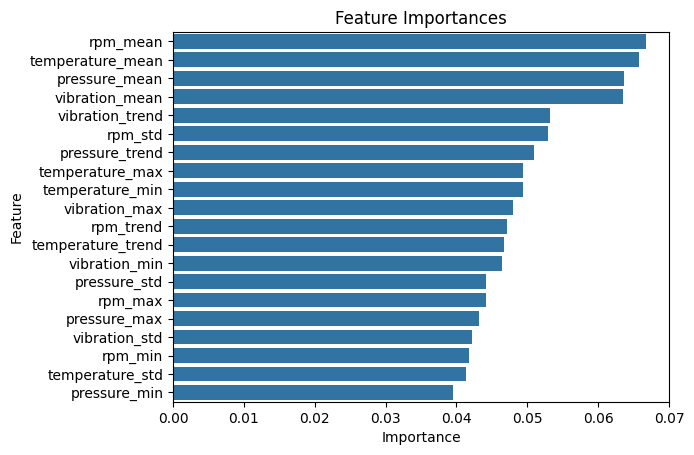

In [6]:
# 02.5 — feature importance
imp = pd.DataFrame({"Feature": feature_cols, "Importance": rf.feature_importances_}).sort_values("Importance", ascending=False)
sns.barplot(y="Feature", x="Importance", data=imp)
plt.title("Feature Importances")
plt.show()
